In [1]:
using Flux, Flux.Data.MNIST
using Flux: onehotbatch, argmax, crossentropy, throttle
using Base.Iterators: repeated
using FluxExtensions
using MLBase: roc, correctrate, precision, recall, f1score, false_positive_rate, false_negative_rate

push!(LOAD_PATH, "../", "/home/jan/dev/anomaly detection/anomaly_detection/src")
using KNNmem
using AnomalyDetection

include("../train_and_track.jl");

In [2]:
# Prepare data

dataPath = "/home/jan/dev/data/loda/public/datasets/numerical"
allData = AnomalyDetection.loaddata(dataPath)

dataset = allData["abalone"]
train, test, clusterdness = AnomalyDetection.makeset(dataset, 0.9, "normal", 0.1, "high")
inputSize = size(train.data, 1)

10

In [3]:
# Model with memory

memoryModel = Chain(
  FluxExtensions.ResDense(inputSize, 64, relu),
  FluxExtensions.ResDense(64,64, relu),
  FluxExtensions.ResDense(64, 2, relu))

memory = KNNmemory(2000, 2, 128, 10)

# Model without memory

classicModel = Chain(
  FluxExtensions.ResDense(inputSize, 64, relu),
  FluxExtensions.ResDense(64,64, relu),
  FluxExtensions.ResDense(64, 2, relu),
  softmax)

Chain(ResDense(Dense(64, 64, NNlib.relu)), ResDense(Dense(64, 64, NNlib.relu)), ResDense(Dense(2, 2, NNlib.relu)), NNlib.softmax)

In [4]:
# Training setup

memLoss(x, y) = trainQuery!(memory, memoryModel(x), y)
memPerformance(x, y) = mean(query(memory, memoryModel(x)) .== y)
memOpt = ADAM(params(memoryModel))

classicLoss(x, y) = crossentropy(classicModel(x), y)
classicOpt = ADAM(params(classicModel))
classicPerformance(x, y) = mean(argmax(classicModel(x)) .== argmax(y))

iterations = 1000
batchSize = 1000
printInterationCount = 100

100

In [5]:
memHistory = trainAndTrack!(memLoss, memPerformance, memOpt, iterations, batchSize, train.data, train.labels, test.data, test.labels, printInterationCount)
classicHistory = trainAndTrack!(classicLoss, classicPerformance, classicOpt, iterations, batchSize, train.data, Flux.onehotbatch(train.labels, 0:1), test.data, Flux.onehotbatch(test.labels, 0:1), printInterationCount)

0.09149620133690665
0.09980172678329172
0.09486651269091771
0.09997563667856521
0.09601288510310317
0.09902711005454004
0.08230594337391746
0.09999003436832679
0.0999940294714094
0.09871780359594268
0.13012520231268235
0.12935172363668057
0.12340550639619056
0.10520446969481895
0.12413142694861344
0.12372998691842797
0.12680416595744012
0.1345911884027295
0.12257251692438538
0.13270690506684896


MVHistory{ValueHistories.History}
  :performance => 10 elements {Int64,Float64}
  :trainLoss => 10 elements {Int64,Float64}

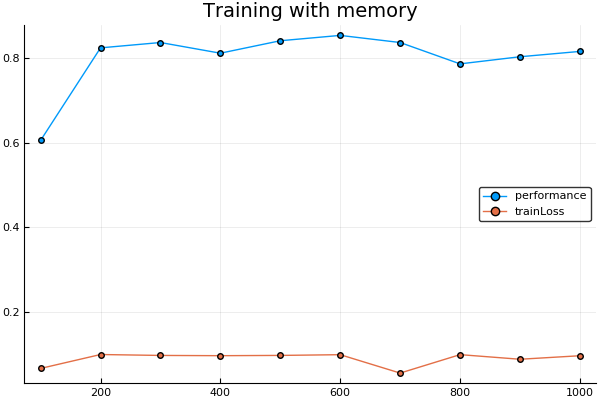

In [6]:
# Plot training

using Plots
pyplot()

plot(memHistory)
plot!(title = "Training with memory")

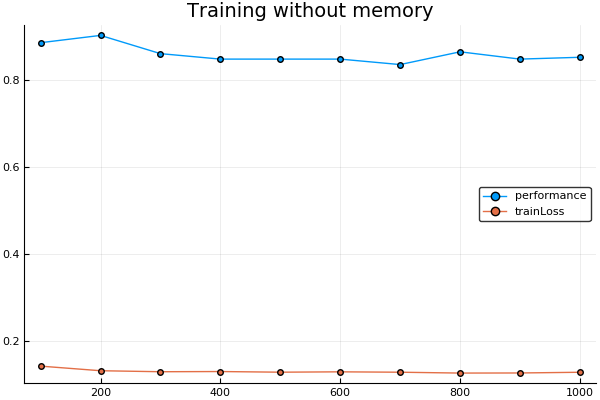

In [10]:
plot(classicHistory)
plot!(title = "Training without memory")

In [8]:
# ROC with memory

rocData = roc(test.labels, query(memory, memoryModel(test.data)))
print(rocData)
print("precision: $(precision(rocData))\n")
print("f1score: $(f1score(rocData))\n")
print("recall: $(recall(rocData))\n")
print("false positive rate: $(false_positive_rate(rocData))\n")
print("equal error rate: $((false_positive_rate(rocData) + false_negative_rate(rocData))/2)\n")

MLBase.ROCNums{Int64}
  p = 22
  n = 216
  tp = 7
  tn = 197
  fp = 19
  fn = 15
precision: 0.2692307692307692
f1score: 0.2916666666666667
recall: 0.3181818181818182
false positive rate: 0.08796296296296297
equal error rate: 0.38489057239057234


In [9]:
# ROC without memory

rocData = roc(test.labels, argmax(classicModel(test.data)))
print(rocData)
print("precision: $(precision(rocData))\n")
print("f1score: $(f1score(rocData))\n")
print("recall: $(recall(rocData))\n")
print("false positive rate: $(false_positive_rate(rocData))\n")
print("equal error rate: $((false_positive_rate(rocData) + false_negative_rate(rocData))/2)\n")

MLBase.ROCNums{Int64}
  p = 22
  n = 216
  tp = 18
  tn = 0
  fp = 216
  fn = 0
precision: 0.07692307692307693
f1score: 0.14285714285714285
recall: 0.8181818181818182
false positive rate: 1.0
equal error rate: 0.5
